# Lexicase Selection Demo

This notebook demonstrates how lexicase selection works, compares it with tournament selection, and shows how to use it in a complete evolutionary algorithm.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from lexicase import lexicase_selection, epsilon_lexicase_selection
from baselines import tournament_selection

# Set random seed for reproducibility
np.random.seed(42)

## Understanding Lexicase Selection

Lexicase selection evaluates individuals on one test case at a time, eliminating those that don't perform as well as the best on that case. This maintains diversity and prevents over-optimization on aggregate fitness.

In [18]:
# Create a diverse fitness landscape
n_individuals = 8
n_cases = 4

# Create fitness matrix where different individuals excel at different cases
fitness_matrix = np.array([
    [10, 2, 3, 1],   # Individual 0: Great at case 0
    [3, 10, 2, 1],   # Individual 1: Great at case 1  
    [2, 3, 10, 1],   # Individual 2: Great at case 2
    [1, 2, 3, 10],   # Individual 3: Great at case 3
    [7, 7, 7, 7],    # Individual 4: Good at everything
    [1, 1, 1, 1],    # Individual 5: Poor at everything
    [6, 8, 4, 5],    # Individual 6: Mixed performance
    [5, 4, 8, 6],    # Individual 7: Mixed performance
])

print("Fitness Matrix:")
print("Rows = individuals, Columns = test cases")
print(fitness_matrix)
print()

# Calculate aggregate fitness (what tournament selection uses)
aggregate_fitness = np.sum(fitness_matrix, axis=1)
print("Aggregate fitness (sum across cases):")
for i, fitness in enumerate(aggregate_fitness):
    print(f"Individual {i}: {fitness}")

Fitness Matrix:
Rows = individuals, Columns = test cases
[[10  2  3  1]
 [ 3 10  2  1]
 [ 2  3 10  1]
 [ 1  2  3 10]
 [ 7  7  7  7]
 [ 1  1  1  1]
 [ 6  8  4  5]
 [ 5  4  8  6]]

Aggregate fitness (sum across cases):
Individual 0: 16
Individual 1: 16
Individual 2: 16
Individual 3: 16
Individual 4: 28
Individual 5: 4
Individual 6: 23
Individual 7: 23


## Comparing Selection Methods

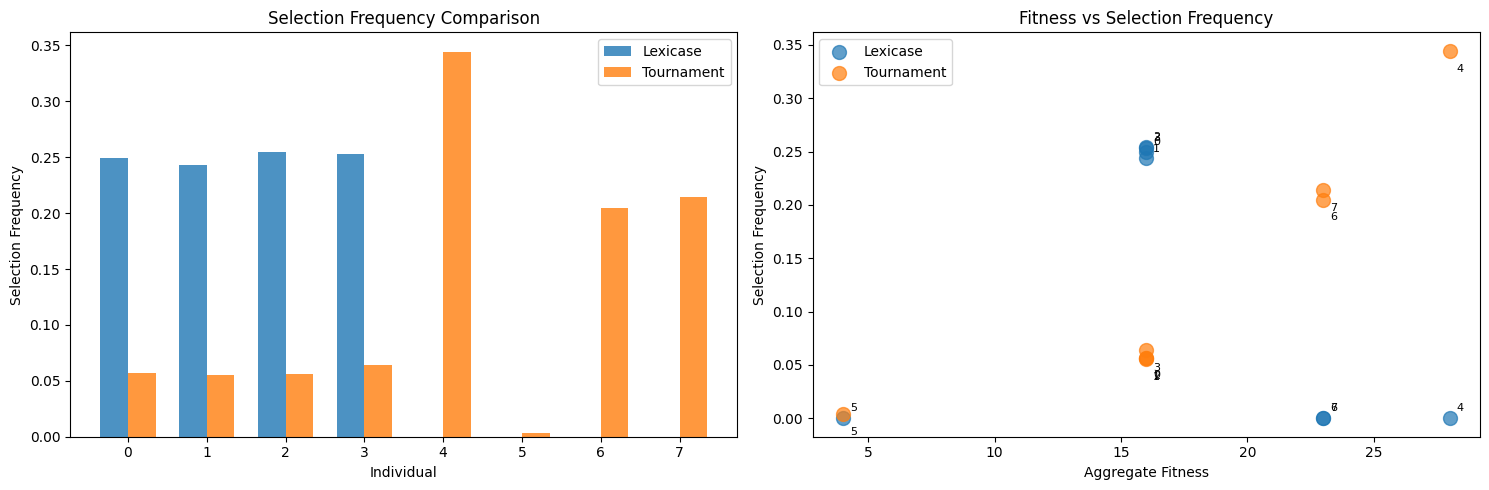


Key Observations:
- Tournament selection heavily favors Individual 4 (highest aggregate fitness)
- Lexicase selection maintains diversity, giving specialists a chance
- Individuals 0-3 excel at specific cases and get selected more often with lexicase


In [19]:
# Compare selection methods
num_selected = 4
n_trials = 1000

# Track selection frequencies
lexicase_counts = np.zeros(n_individuals)
tournament_counts = np.zeros(n_individuals)

for trial in range(n_trials):
    # Lexicase selection
    lex_selected = lexicase_selection(fitness_matrix, num_selected, seed=trial)
    for idx in lex_selected:
        lexicase_counts[idx] += 1
    
    # Tournament selection
    tour_selected = tournament_selection(fitness_matrix, num_selected, tournament_size=3, seed=trial)
    for idx in tour_selected:
        tournament_counts[idx] += 1

# Normalize to frequencies
lexicase_freq = lexicase_counts / (n_trials * num_selected)
tournament_freq = tournament_counts / (n_trials * num_selected)

# Plot comparison
x = np.arange(n_individuals)
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Selection frequencies
ax1.bar(x - width/2, lexicase_freq, width, label='Lexicase', alpha=0.8)
ax1.bar(x + width/2, tournament_freq, width, label='Tournament', alpha=0.8)
ax1.set_xlabel('Individual')
ax1.set_ylabel('Selection Frequency')
ax1.set_title('Selection Frequency Comparison')
ax1.legend()
ax1.set_xticks(x)

# Aggregate fitness vs selection frequency
ax2.scatter(aggregate_fitness, lexicase_freq, label='Lexicase', alpha=0.7, s=100)
ax2.scatter(aggregate_fitness, tournament_freq, label='Tournament', alpha=0.7, s=100)
ax2.set_xlabel('Aggregate Fitness')
ax2.set_ylabel('Selection Frequency')
ax2.set_title('Fitness vs Selection Frequency')
ax2.legend()

# Add individual labels
for i in range(n_individuals):
    ax2.annotate(f'{i}', (aggregate_fitness[i], lexicase_freq[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax2.annotate(f'{i}', (aggregate_fitness[i], tournament_freq[i]), 
                xytext=(5, -15), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Tournament selection heavily favors Individual 4 (highest aggregate fitness)")
print("- Lexicase selection maintains diversity, giving specialists a chance")
print("- Individuals 0-3 excel at specific cases and get selected more often with lexicase")

## Epsilon Lexicase Selection

Epsilon lexicase uses a tolerance value to consider individuals "good enough" rather than requiring exact equality.

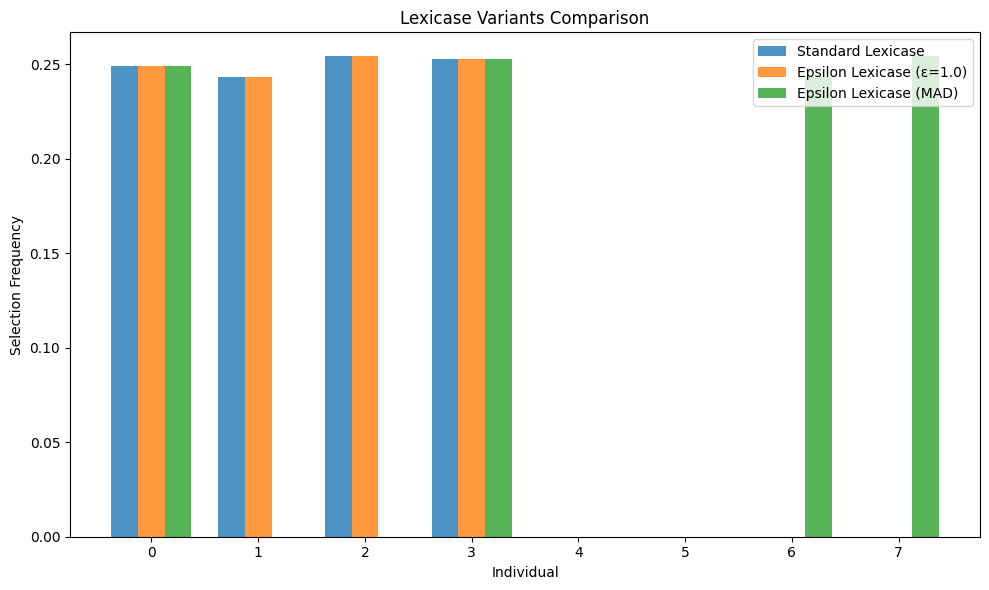


Epsilon Effects:
- Fixed epsilon (1.0) increases diversity by being more tolerant
- MAD-based epsilon adapts to each test case's difficulty


In [20]:
# Compare standard vs epsilon lexicase
epsilon_counts = np.zeros(n_individuals)
mad_epsilon_counts = np.zeros(n_individuals)

for trial in range(n_trials):
    # Epsilon lexicase with fixed epsilon
    eps_selected = epsilon_lexicase_selection(fitness_matrix, num_selected, epsilon=1.0, seed=trial)
    for idx in eps_selected:
        epsilon_counts[idx] += 1
    
    # Epsilon lexicase with MAD-based epsilon (default)
    mad_selected = epsilon_lexicase_selection(fitness_matrix, num_selected, seed=trial)
    for idx in mad_selected:
        mad_epsilon_counts[idx] += 1

epsilon_freq = epsilon_counts / (n_trials * num_selected)
mad_epsilon_freq = mad_epsilon_counts / (n_trials * num_selected)

# Plot epsilon comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(n_individuals)
width = 0.25

ax.bar(x - width, lexicase_freq, width, label='Standard Lexicase', alpha=0.8)
ax.bar(x, epsilon_freq, width, label='Epsilon Lexicase (ε=1.0)', alpha=0.8)
ax.bar(x + width, mad_epsilon_freq, width, label='Epsilon Lexicase (MAD)', alpha=0.8)

ax.set_xlabel('Individual')
ax.set_ylabel('Selection Frequency')
ax.set_title('Lexicase Variants Comparison')
ax.legend()
ax.set_xticks(x)

plt.tight_layout()
plt.show()

print("\nEpsilon Effects:")
print("- Fixed epsilon (1.0) increases diversity by being more tolerant")
print("- MAD-based epsilon adapts to each test case's difficulty")

## Multi-Regime Function Learning

Now let's explore a problem where there IS a global optimum, but specialists help find it! We'll evolve neural networks to learn a complex function with multiple regimes. While there's one "perfect" network that gets everything right, specialists focusing on different regimes help guide the search toward this global optimum.

In [29]:
# Define a complex target function with multiple regimes
def complex_target_function(x):
    """
    A single complex function with different behaviors in different regimes.
    This represents the TRUE function we want to learn (global optimum).
    """
    # Normalize input to [0,1] for regime detection
    x_norm = (x + 2) / 4  # Map [-2,2] -> [0,1]
    
    # Different regimes based on input value
    result = np.zeros_like(x)
    
    # Regime 1: x in [-2, -1] -> Linear trend
    mask1 = x <= -1
    result[mask1] = 0.5 * x[mask1] + 0.5
    
    # Regime 2: x in [-1, 0] -> Sine wave  
    mask2 = (x > -1) & (x <= 0)
    result[mask2] = 0.7 * np.sin(3 * np.pi * x[mask2]) + 0.2
    
    # Regime 3: x in [0, 1] -> Quadratic
    mask3 = (x > 0) & (x <= 1) 
    result[mask3] = -0.8 * x[mask3]**2 + 0.4 * x[mask3] + 0.3
    
    # Regime 4: x in [1, 2] -> Exponential decay
    mask4 = x > 1
    result[mask4] = 0.6 * np.exp(-(x[mask4] - 1)**2) + 0.1
    
    return result

def simple_neural_network(weights, x):
    """
    Simple 2-layer neural network: input -> hidden(8 nodes) -> output
    weights: [input_to_hidden(8), hidden_bias(8), hidden_to_output(8), output_bias(1)]
    Total: 25 parameters
    """
    # Handle scalar input
    x_input = np.atleast_1d(x)
    
    # Unpack weights
    w_ih = weights[:8]     # input to hidden weights
    b_h = weights[8:16]    # hidden biases  
    w_ho = weights[16:24]  # hidden to output weights
    b_o = weights[24]      # output bias
    
    # Forward pass for each input
    results = []
    for xi in x_input:
        hidden = np.tanh(w_ih * xi + b_h)  # Hidden layer activation
        output = np.sum(w_ho * hidden) + b_o  # Output layer
        results.append(output)
    
    return np.array(results) if len(results) > 1 else results[0]

def create_regime_test_cases(n_points_per_regime=10):
    """
    Create test cases for different regimes of the complex function.
    Each regime tests a different part of the input space.
    """
    test_cases = []
    
    # Regime 1: Linear region [-2, -1]
    x1 = np.linspace(-2, -1, n_points_per_regime)
    y1 = complex_target_function(x1)
    test_cases.append(("Linear_Regime", x1, y1))
    
    # Regime 2: Sine region [-1, 0]
    x2 = np.linspace(-1, 0, n_points_per_regime)
    y2 = complex_target_function(x2)
    test_cases.append(("Sine_Regime", x2, y2))
    
    # Regime 3: Quadratic region [0, 1]
    x3 = np.linspace(0, 1, n_points_per_regime)
    y3 = complex_target_function(x3)
    test_cases.append(("Quadratic_Regime", x3, y3))
    
    # Regime 4: Exponential region [1, 2]
    x4 = np.linspace(1, 2, n_points_per_regime)
    y4 = complex_target_function(x4)
    test_cases.append(("Exponential_Regime", x4, y4))
    
    # Overall test (fewer points to not dominate)
    x_overall = np.linspace(-2, 2, n_points_per_regime)
    y_overall = complex_target_function(x_overall)
    test_cases.append(("Overall_Function", x_overall, y_overall))
    
    return test_cases

def evaluate_individual(individual, test_cases):
    """
    Evaluate how well an individual approximates different regimes of the target function.
    """
    fitness_values = []
    
    for regime_name, eval_points, target_values in test_cases:
        # Evaluate neural network on these points
        predictions = simple_neural_network(individual, eval_points)
        
        # Calculate fitness as negative mean squared error
        mse = np.mean((predictions - target_values) ** 2)
        fitness = -mse  # Higher is better
        fitness_values.append(fitness)
    
    return np.array(fitness_values)

def mutate(individual, mutation_rate=0.3, mutation_strength=0.15):
    """Apply Gaussian mutation to neural network weights."""
    mutated = individual.copy()
    mask = np.random.random(len(individual)) < mutation_rate
    mutated[mask] += np.random.normal(0, mutation_strength, np.sum(mask))
    return mutated

def evolutionary_algorithm(population_size=500, generations=150, selection_method='lexicase', mutation_rate=0.3):
    """
    Evolutionary algorithm for evolving neural networks to learn a complex multi-regime function.
    """
    # Create regime-based test cases
    test_cases = create_regime_test_cases()
    
    # Neural network has 25 parameters
    n_params = 100
    
    # Initialize population with small random weights
    population = [np.random.normal(0, 0.3, n_params) for _ in range(population_size)]
    
    # Track metrics
    best_fitness_history = []
    diversity_history = []
    best_individual_history = []
    regime_fitness_history = []  # Track fitness per regime
    
    for generation in range(generations):
        # Evaluate population
        fitness_matrix = np.array([evaluate_individual(ind, test_cases) for ind in population])
        
        # Track best individual and fitness
        best_idx = np.argmax(np.mean(fitness_matrix, axis=1))
        best_fitness = np.mean(fitness_matrix[best_idx])
        best_fitness_history.append(best_fitness)
        best_individual_history.append(population[best_idx].copy())
        
        # Track regime-specific fitness of best individual
        best_regime_fitness = fitness_matrix[best_idx]
        regime_fitness_history.append(best_regime_fitness.copy())
        
        # Measure diversity (average pairwise distance)
        distances = []
        for i in range(len(population)):
            for j in range(i+1, len(population)):
                dist = np.linalg.norm(np.array(population[i]) - np.array(population[j]))
                distances.append(dist)
        diversity = np.mean(distances) if distances else 0
        diversity_history.append(diversity)
        
        # Selection
        if selection_method == 'lexicase':
            selected_indices = lexicase_selection(fitness_matrix, population_size, seed=generation)
        elif selection_method == 'epsilon_lexicase':
            selected_indices = epsilon_lexicase_selection(fitness_matrix, population_size, seed=generation)
        elif selection_method == 'tournament':
            selected_indices = tournament_selection(fitness_matrix, population_size, tournament_size=3, seed=generation)
        
        # Create next generation
        new_population = []
        for idx in selected_indices:
            parent = population[idx]
            child = mutate(parent, mutation_rate)
            new_population.append(child)
        
        population = new_population
        
        # Print progress
        if generation % 30 == 0:
            print(f"Generation {generation}: Best fitness = {best_fitness:.3f}")
    
    return best_fitness_history, diversity_history, best_individual_history, test_cases, regime_fitness_history

# Run evolution with different selection methods
print("Evolving neural networks to learn a complex multi-regime function...")
print("The target function has 4 different regimes: Linear, Sine, Quadratic, and Exponential")
print("There IS a global optimum, but specialists help find it!")
print("This may take a moment...\n")

np.random.seed(42)  # For reproducibility
lexicase_fitness, lexicase_diversity, lexicase_best, test_cases, lexicase_regime_history = evolutionary_algorithm(selection_method='lexicase')

np.random.seed(42)
epsilon_fitness, epsilon_diversity, epsilon_best, _, epsilon_regime_history = evolutionary_algorithm(selection_method='epsilon_lexicase')

np.random.seed(42)  
tournament_fitness, tournament_diversity, tournament_best, _, tournament_regime_history = evolutionary_algorithm(selection_method='tournament')

print("\nEvolution complete!")

Evolving neural networks to learn a complex multi-regime function...
The target function has 4 different regimes: Linear, Sine, Quadratic, and Exponential
There IS a global optimum, but specialists help find it!
This may take a moment...

Generation 0: Best fitness = -0.074
Generation 30: Best fitness = -0.071
Generation 60: Best fitness = -0.069
Generation 90: Best fitness = -0.078
Generation 120: Best fitness = -0.077
Generation 0: Best fitness = -0.074
Generation 30: Best fitness = -0.070
Generation 60: Best fitness = -0.070
Generation 90: Best fitness = -0.070
Generation 120: Best fitness = -0.067
Generation 0: Best fitness = -0.074
Generation 30: Best fitness = -0.072
Generation 60: Best fitness = -0.070
Generation 90: Best fitness = -0.070
Generation 120: Best fitness = -0.069

Evolution complete!


1. Target Function Overview:


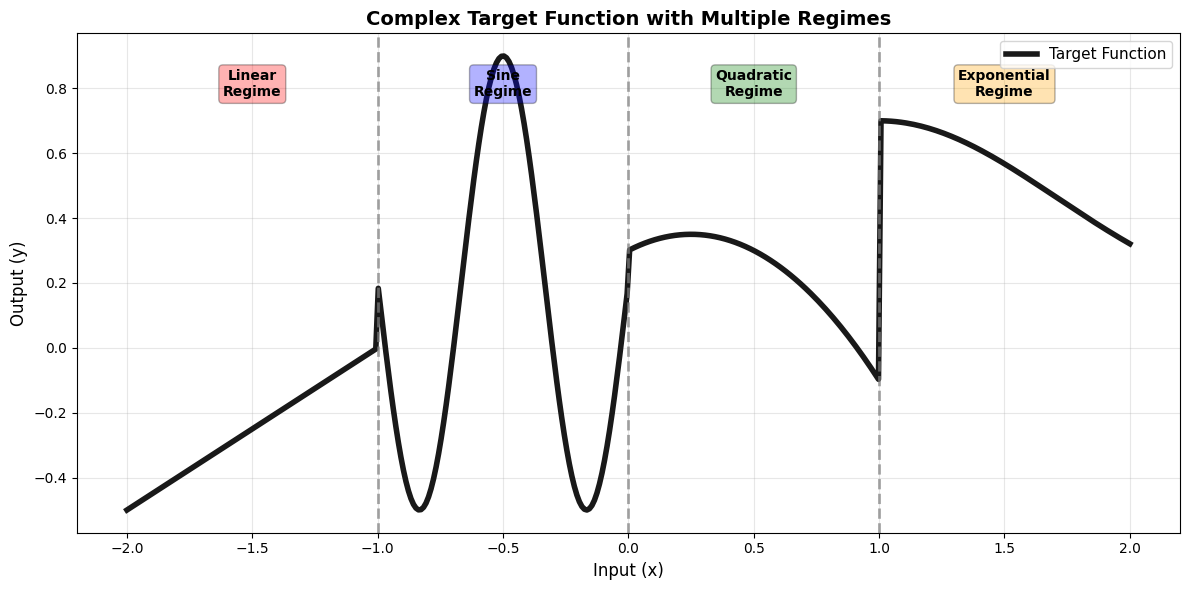

This is the SINGLE function we want to learn!
Different regimes require different 'skills' but there IS one optimal solution.

2. Regime-Specific Approximation Results:


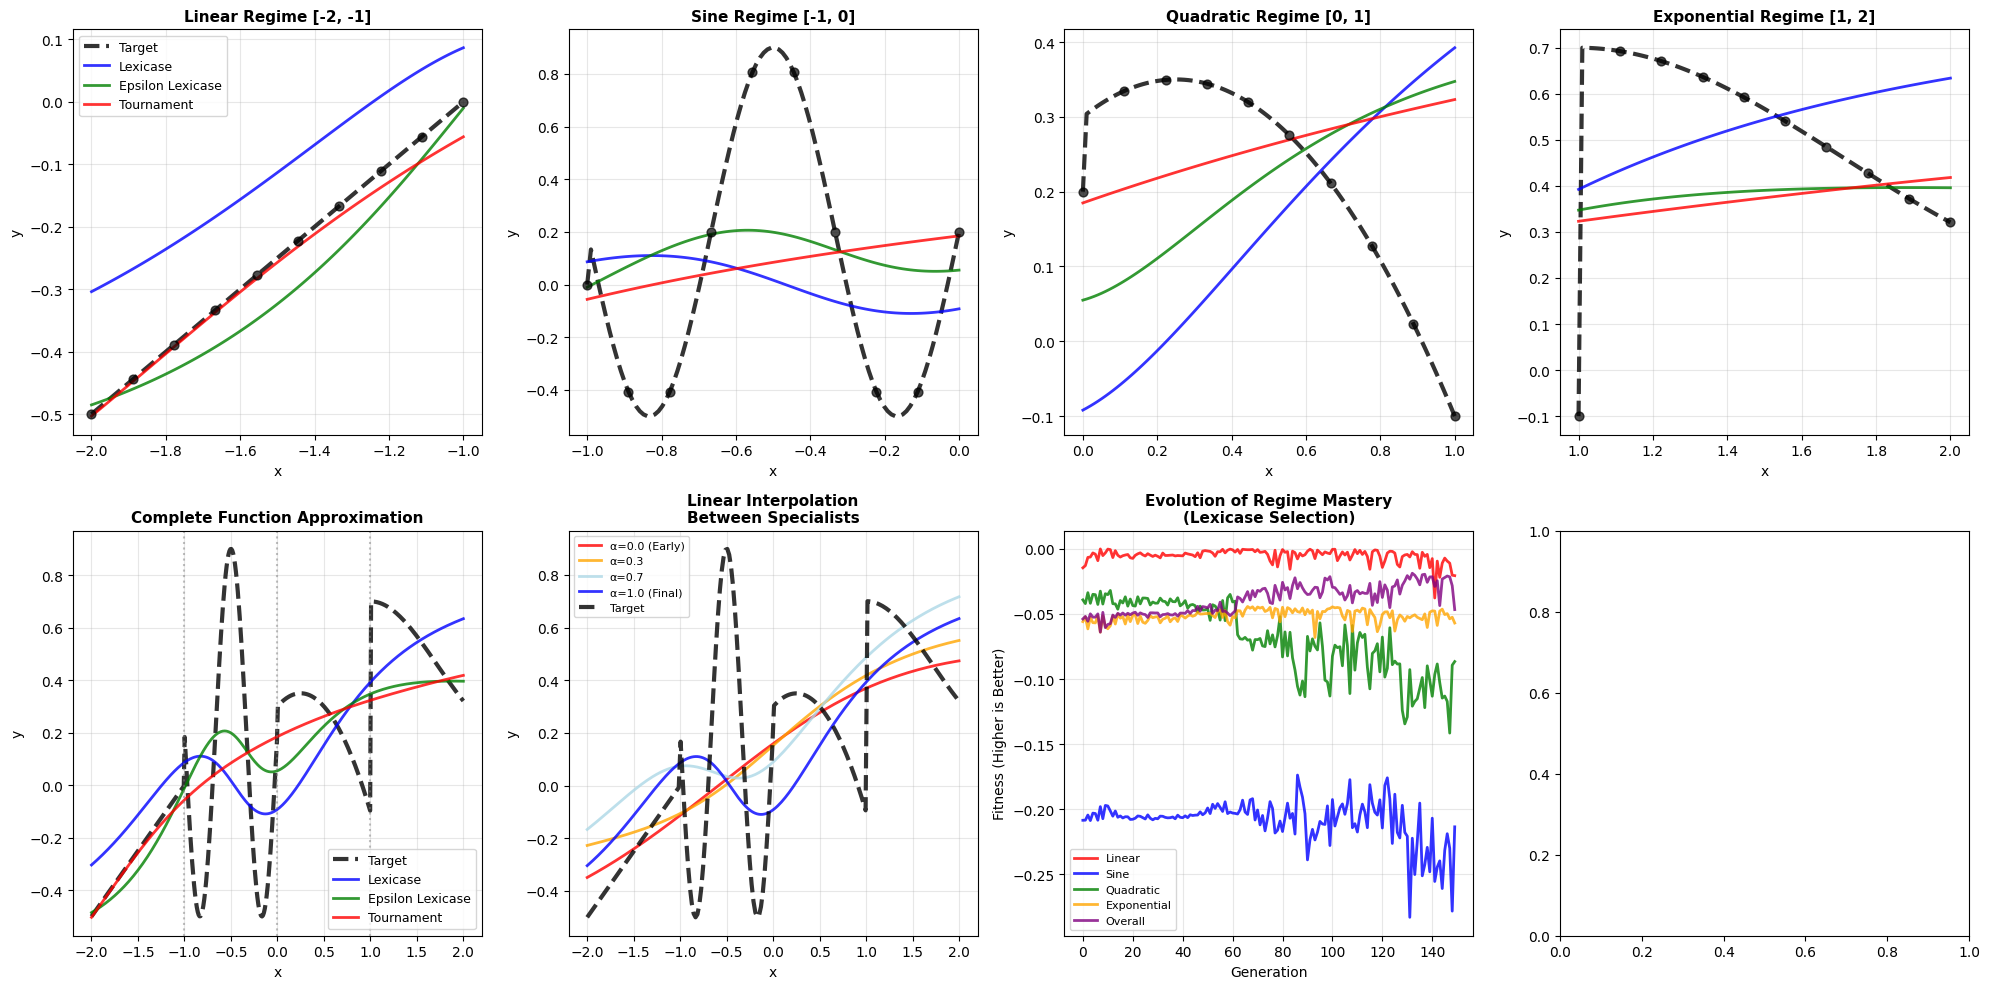


3. Evolution Metrics Comparison:


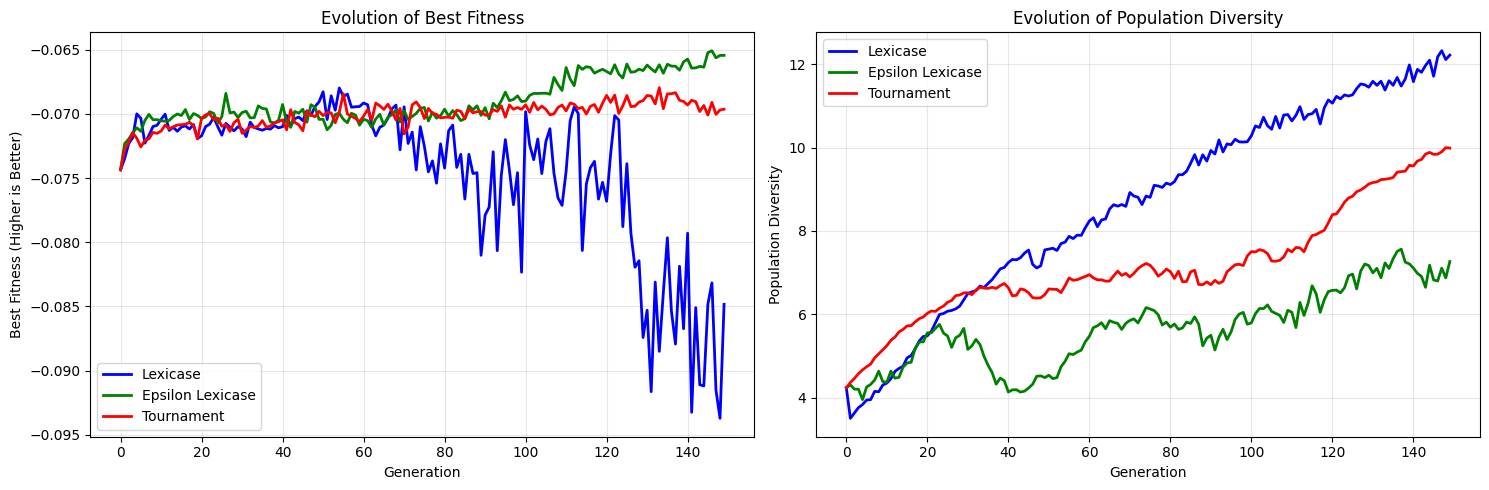


4. Selection Method Comparison:


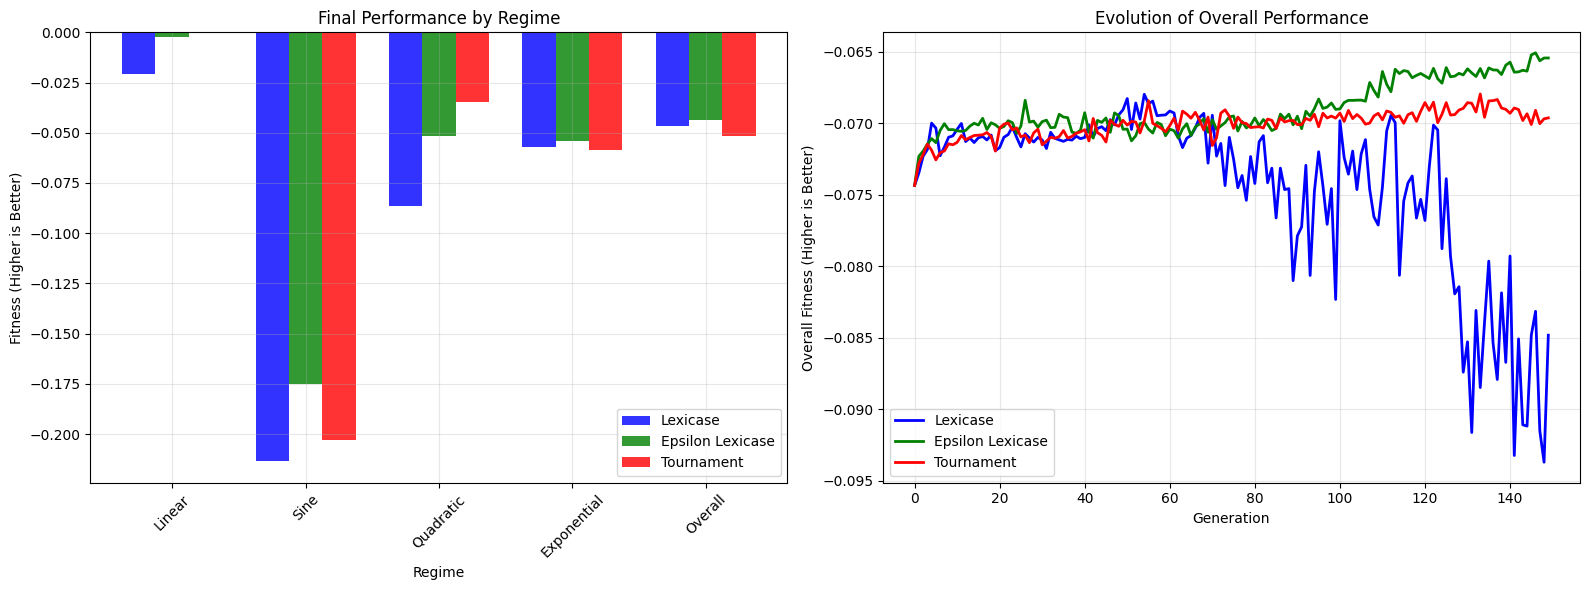


5. Regime-Specific Performance Analysis:


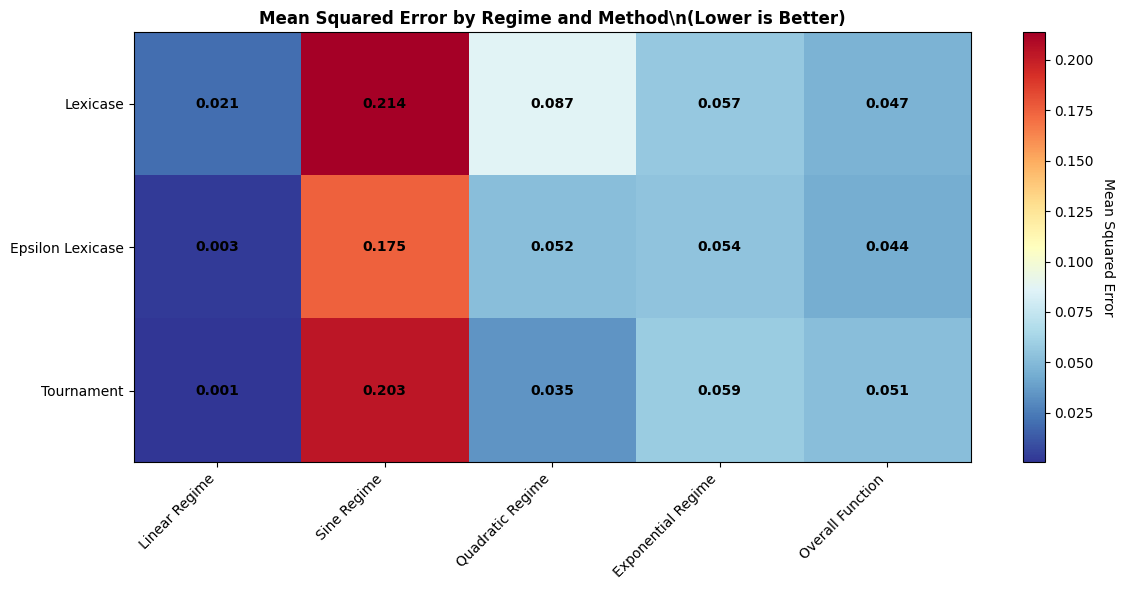


Detailed Results:
Final Overall Fitness (Higher is Better):
  Lexicase:         -0.085
  Epsilon Lexicase: -0.065
  Tournament:       -0.070

Final Population Diversity:
  Lexicase:         12.220
  Epsilon Lexicase: 7.265
  Tournament:       9.989

Regime-Specific MSE (Lower is Better):

Lexicase:
  Linear Regime: 0.0205
  Sine Regime: 0.2135
  Quadratic Regime: 0.0865
  Exponential Regime: 0.0569
  Overall Function: 0.0466

Epsilon Lexicase:
  Linear Regime: 0.0026
  Sine Regime: 0.1751
  Quadratic Regime: 0.0515
  Exponential Regime: 0.0542
  Overall Function: 0.0439

Tournament:
  Linear Regime: 0.0006
  Sine Regime: 0.2031
  Quadratic Regime: 0.0345
  Exponential Regime: 0.0587
  Overall Function: 0.0514

Key Insights for Multi-Regime Learning:
- There IS a global optimum (one function that gets all regimes right)
- Lexicase selection maintains specialists who help explore different regimes
- These specialists guide the search toward the global optimum more effectively
- Tourname

In [30]:
# First, let's visualize the target function to understand what we're learning
def show_target_function():
    """Display the complex target function with regime boundaries."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Create dense points for smooth visualization
    x_dense = np.linspace(-2, 2, 400)
    y_target = complex_target_function(x_dense)
    
    # Plot the complete target function
    ax.plot(x_dense, y_target, 'k-', linewidth=4, label='Target Function', alpha=0.9)
    
    # Highlight regime boundaries
    regime_boundaries = [-1, 0, 1]
    colors = ['red', 'blue', 'green', 'orange']
    regime_names = ['Linear', 'Sine', 'Quadratic', 'Exponential']
    
    for i, boundary in enumerate(regime_boundaries):
        ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add regime labels
    regime_centers = [-1.5, -0.5, 0.5, 1.5]
    for i, (center, name, color) in enumerate(zip(regime_centers, regime_names, colors)):
        ax.text(center, ax.get_ylim()[1] * 0.8, f'{name}\nRegime', 
                horizontalalignment='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    
    ax.set_xlabel('Input (x)', fontsize=12)
    ax.set_ylabel('Output (y)', fontsize=12)
    ax.set_title('Complex Target Function with Multiple Regimes', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("This is the SINGLE function we want to learn!")
    print("Different regimes require different 'skills' but there IS one optimal solution.")

# Visualize function approximations with regime analysis
def plot_regime_approximations():
    """Plot how well each method approximated different regimes."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Get the best individuals from each method
    best_lexicase = lexicase_best[-1]
    best_epsilon = epsilon_best[-1] 
    best_tournament = tournament_best[-1]
    
    methods = [
        ('Lexicase', best_lexicase, 'blue'),
        ('Epsilon Lexicase', best_epsilon, 'green'), 
        ('Tournament', best_tournament, 'red')
    ]
    
    # First row: Individual regimes
    regime_ranges = [(-2, -1), (-1, 0), (0, 1), (1, 2)]
    regime_names = ['Linear', 'Sine', 'Quadratic', 'Exponential']
    
    for i, ((x_min, x_max), regime_name) in enumerate(zip(regime_ranges, regime_names)):
        ax = axes[0, i]
        
        # Create dense evaluation points for this regime
        x_dense = np.linspace(x_min, x_max, 100)
        y_target = complex_target_function(x_dense)
        
        # Plot target function for this regime
        ax.plot(x_dense, y_target, 'k--', linewidth=3, label='Target', alpha=0.8)
        
        # Plot test points used in evaluation
        x_test = np.linspace(x_min, x_max, 10)
        y_test_target = complex_target_function(x_test)
        ax.scatter(x_test, y_test_target, c='black', s=40, zorder=5, alpha=0.7)
        
        # Plot each method's approximation
        for method_name, individual, color in methods:
            y_pred = simple_neural_network(individual, x_dense)
            ax.plot(x_dense, y_pred, color=color, linewidth=2, label=method_name, alpha=0.8)
        
        ax.set_title(f'{regime_name} Regime [{x_min}, {x_max}]', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend(fontsize=9)
    
    # Second row: Overall function and specialist interpolation
    ax_overall = axes[1, 0]
    
    # Plot complete function
    x_full = np.linspace(-2, 2, 400)
    y_target_full = complex_target_function(x_full)
    ax_overall.plot(x_full, y_target_full, 'k--', linewidth=3, label='Target', alpha=0.8)
    
    # Plot each method's complete approximation
    for method_name, individual, color in methods:
        y_pred_full = simple_neural_network(individual, x_full)
        ax_overall.plot(x_full, y_pred_full, color=color, linewidth=2, label=method_name, alpha=0.8)
    
    # Add regime boundaries
    for boundary in [-1, 0, 1]:
        ax_overall.axvline(x=boundary, color='gray', linestyle=':', alpha=0.5)
    
    ax_overall.set_title('Complete Function Approximation', fontsize=11, fontweight='bold')
    ax_overall.set_xlabel('x')
    ax_overall.set_ylabel('y')
    ax_overall.grid(True, alpha=0.3)
    ax_overall.legend(fontsize=9)
    
    # Show linear interpolation between specialist behaviors
    ax_interp = axes[1, 1]
    plot_specialist_interpolation(ax_interp)
    
    # Show evolution of regime mastery
    ax_mastery = axes[1, 2]
    plot_regime_mastery_evolution(ax_mastery)
    
    plt.tight_layout()
    plt.show()

def plot_specialist_interpolation(ax):
    """Show how specialists can be linearly interpolated."""
    # Find some interesting individuals from the population history
    # We'll take individuals from different points in evolution
    
    early_ind = lexicase_best[20] if len(lexicase_best) > 20 else lexicase_best[5]
    mid_ind = lexicase_best[len(lexicase_best)//2]
    final_ind = lexicase_best[-1]
    
    x_range = np.linspace(-2, 2, 200)
    
    # Show interpolation between early and final individual
    alphas = [0.0, 0.3, 0.7, 1.0]
    colors = ['red', 'orange', 'lightblue', 'blue']
    
    for alpha, color in zip(alphas, colors):
        # Linear interpolation of weights
        interp_weights = (1 - alpha) * early_ind + alpha * final_ind
        y_interp = simple_neural_network(interp_weights, x_range)
        
        label = f'α={alpha:.1f}' + (' (Early)' if alpha == 0 else ' (Final)' if alpha == 1 else '')
        ax.plot(x_range, y_interp, color=color, linewidth=2, alpha=0.8, label=label)
    
    # Show target
    y_target = complex_target_function(x_range)
    ax.plot(x_range, y_target, 'k--', linewidth=3, label='Target', alpha=0.8)
    
    ax.set_title('Linear Interpolation\nBetween Specialists', fontsize=11, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

def plot_regime_mastery_evolution(ax):
    """Show how mastery of each regime evolved over time."""
    generations = range(len(lexicase_regime_history))
    regime_names = ['Linear', 'Sine', 'Quadratic', 'Exponential', 'Overall']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    lexicase_regimes = np.array(lexicase_regime_history)
    
    for i, (regime_name, color) in enumerate(zip(regime_names, colors)):
        if i < lexicase_regimes.shape[1]:
            ax.plot(generations, lexicase_regimes[:, i], 
                   color=color, linewidth=2, label=f'{regime_name}', alpha=0.8)
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness (Higher is Better)')
    ax.set_title('Evolution of Regime Mastery\n(Lexicase Selection)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

print("1. Target Function Overview:")
show_target_function()

print("\n2. Regime-Specific Approximation Results:")
plot_regime_approximations()

# Plot evolution metrics
def plot_evolution_metrics():
    """Plot fitness and diversity evolution."""
    generations = range(len(lexicase_fitness))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Best fitness over time
    ax1.plot(generations, lexicase_fitness, label='Lexicase', linewidth=2, color='blue')
    ax1.plot(generations, epsilon_fitness, label='Epsilon Lexicase', linewidth=2, color='green')
    ax1.plot(generations, tournament_fitness, label='Tournament', linewidth=2, color='red')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Fitness (Higher is Better)')
    ax1.set_title('Evolution of Best Fitness')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Population diversity over time
    ax2.plot(generations, lexicase_diversity, label='Lexicase', linewidth=2, color='blue')
    ax2.plot(generations, epsilon_diversity, label='Epsilon Lexicase', linewidth=2, color='green')
    ax2.plot(generations, tournament_diversity, label='Tournament', linewidth=2, color='red')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Population Diversity')
    ax2.set_title('Evolution of Population Diversity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Regime-specific performance analysis
def analyze_regime_performance():
    """Analyze how well each method performed on individual regimes."""
    
    # Evaluate final individuals on each regime
    methods_data = [
        ('Lexicase', lexicase_best[-1]),
        ('Epsilon Lexicase', epsilon_best[-1]),
        ('Tournament', tournament_best[-1])
    ]
    
    performance_matrix = []
    for method_name, individual in methods_data:
        performance = []
        for regime_name, eval_points, target_values in test_cases:
            predictions = simple_neural_network(individual, eval_points)
            mse = np.mean((predictions - target_values) ** 2)
            performance.append(mse)
        performance_matrix.append(performance)
    
    performance_matrix = np.array(performance_matrix)
    regime_names = [case[0].replace('_', ' ') for case in test_cases]
    
    # Create heatmap
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    im = ax.imshow(performance_matrix, cmap='RdYlBu_r', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(range(len(regime_names)))
    ax.set_xticklabels(regime_names, rotation=45, ha='right')
    ax.set_yticks(range(len(methods_data)))
    ax.set_yticklabels([name for name, _ in methods_data])
    
    # Add text annotations
    for i in range(len(methods_data)):
        for j in range(len(regime_names)):
            text = ax.text(j, i, f'{performance_matrix[i, j]:.3f}', 
                          ha="center", va="center", color="black", fontweight='bold')
    
    ax.set_title('Mean Squared Error by Regime and Method\\n(Lower is Better)', 
                 fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Mean Squared Error', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    return performance_matrix, regime_names

# Show how different selection methods compare across regimes
def plot_selection_comparison():
    """Compare selection methods across regimes and overall performance."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Regime mastery comparison
    regime_names_short = ['Linear', 'Sine', 'Quadratic', 'Exponential', 'Overall']
    methods = ['Lexicase', 'Epsilon Lexicase', 'Tournament']
    colors = ['blue', 'green', 'red']
    
    # Get final regime fitness for each method
    final_regimes = [
        lexicase_regime_history[-1],
        epsilon_regime_history[-1], 
        tournament_regime_history[-1]
    ]
    
    x = np.arange(len(regime_names_short))
    width = 0.25
    
    for i, (method, regime_fitness, color) in enumerate(zip(methods, final_regimes, colors)):
        ax1.bar(x + i*width, regime_fitness, width, label=method, color=color, alpha=0.8)
    
    ax1.set_xlabel('Regime')
    ax1.set_ylabel('Fitness (Higher is Better)')
    ax1.set_title('Final Performance by Regime')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(regime_names_short, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Evolution comparison
    generations = range(len(lexicase_fitness))
    
    ax2.plot(generations, lexicase_fitness, label='Lexicase', linewidth=2, color='blue')
    ax2.plot(generations, epsilon_fitness, label='Epsilon Lexicase', linewidth=2, color='green')
    ax2.plot(generations, tournament_fitness, label='Tournament', linewidth=2, color='red')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Overall Fitness (Higher is Better)')
    ax2.set_title('Evolution of Overall Performance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Execute all visualizations
print("\n3. Evolution Metrics Comparison:")
plot_evolution_metrics()

print("\n4. Selection Method Comparison:")
plot_selection_comparison()

print("\n5. Regime-Specific Performance Analysis:")
performance_matrix, regime_names = analyze_regime_performance()

# Print detailed results
print("\nDetailed Results:")
print("="*60)
print(f"Final Overall Fitness (Higher is Better):")
print(f"  Lexicase:         {lexicase_fitness[-1]:.3f}")
print(f"  Epsilon Lexicase: {epsilon_fitness[-1]:.3f}")
print(f"  Tournament:       {tournament_fitness[-1]:.3f}")

print(f"\nFinal Population Diversity:")
print(f"  Lexicase:         {lexicase_diversity[-1]:.3f}")
print(f"  Epsilon Lexicase: {epsilon_diversity[-1]:.3f}")
print(f"  Tournament:       {tournament_diversity[-1]:.3f}")

print(f"\nRegime-Specific MSE (Lower is Better):")
methods = ['Lexicase', 'Epsilon Lexicase', 'Tournament']
for i, method in enumerate(methods):
    print(f"\n{method}:")
    for j, regime_name in enumerate(regime_names):
        print(f"  {regime_name}: {performance_matrix[i, j]:.4f}")

print("\n" + "="*60)
print("Key Insights for Multi-Regime Learning:")
print("- There IS a global optimum (one function that gets all regimes right)")
print("- Lexicase selection maintains specialists who help explore different regimes")
print("- These specialists guide the search toward the global optimum more effectively")
print("- Tournament selection often converges to mediocre generalists")
print("- The linear interpolation shows how specialist knowledge can be combined")
print("- Notice which method achieves the best OVERALL performance!")

In [ ]:
# Try these experiments to explore different aspects!

# Experiment 1: More complex target functions
def harder_complex_function(x):
    """A more challenging multi-regime function."""
    result = np.zeros_like(x)
    
    # Regime 1: Oscillating decay
    mask1 = x <= -0.5
    result[mask1] = np.exp(x[mask1] + 2) * np.sin(4 * np.pi * x[mask1])
    
    # Regime 2: Polynomial chaos
    mask2 = (x > -0.5) & (x <= 0.5)
    result[mask2] = x[mask2]**3 - 2*x[mask2]**2 + 0.5*x[mask2] + 0.1*np.sin(10*np.pi*x[mask2])
    
    # Regime 3: Step function with noise
    mask3 = (x > 0.5) & (x <= 1.5)
    result[mask3] = np.sign(x[mask3] - 1) + 0.2*np.random.normal(0, 0.1, np.sum(mask3))
    
    # Regime 4: Fractal-like behavior
    mask4 = x > 1.5
    result[mask4] = 0.5 * np.sin(2*np.pi*x[mask4]) * np.cos(8*np.pi*x[mask4])
    
    return result

# Experiment 2: Deeper neural networks
def deeper_neural_network(weights, x):
    """
    Deeper network: input -> hidden(6) -> hidden(6) -> hidden(3) -> output
    Total: 6 + 6 + 36 + 6 + 18 + 3 + 3 + 1 = 79 parameters
    """
    if len(weights) != 79:
        # Fallback to simpler network
        return simple_neural_network(weights[:25], x)
    
    x_input = np.atleast_1d(x)
    results = []
    
    for xi in x_input:
        # Layer 1: input -> 6 nodes
        w1 = weights[:6]
        b1 = weights[6:12]
        h1 = np.tanh(w1 * xi + b1)
        
        # Layer 2: 6 -> 6 nodes
        w2 = weights[12:48].reshape(6, 6)
        b2 = weights[48:54]
        h2 = np.tanh(np.dot(h1, w2) + b2)
        
        # Layer 3: 6 -> 3 nodes
        w3 = weights[54:72].reshape(6, 3)
        b3 = weights[72:75]
        h3 = np.tanh(np.dot(h2, w3) + b3)
        
        # Output layer: 3 -> 1
        w4 = weights[75:78]
        b4 = weights[78]
        output = np.dot(h3, w4) + b4
        
        results.append(output)
    
    return np.array(results) if len(results) > 1 else results[0]

# Experiment 3: Alternative regime definitions
def create_overlapping_regime_tests():
    """Create overlapping regime tests to increase difficulty."""
    test_cases = []
    
    # Overlapping regimes
    ranges = [(-2, -0.5), (-1, 0.5), (-0.5, 1), (0.5, 2)]
    names = ['Early_Overlap', 'Mid_Left_Overlap', 'Mid_Right_Overlap', 'Late_Overlap']
    
    for name, (x_min, x_max) in zip(names, ranges):
        x_test = np.linspace(x_min, x_max, 12)
        y_test = complex_target_function(x_test)
        test_cases.append((name, x_test, y_test))
    
    return test_cases

print("Experimental Variations to Explore:")
print("="*50)
print("1. More Complex Target Functions:")
print("   - Replace 'complex_target_function' with 'harder_complex_function'")
print("   - This adds oscillating decay, polynomial chaos, noisy steps, and fractals")
print()
print("2. Deeper Neural Networks:")
print("   - Replace 'simple_neural_network' with 'deeper_neural_network'")
print("   - Change n_params from 25 to 79 in evolutionary_algorithm")
print("   - Creates 4-layer networks that can learn more complex mappings")
print()
print("3. Overlapping Regime Tests:")
print("   - Use 'create_overlapping_regime_tests()' instead of 'create_regime_test_cases()'")
print("   - Makes regimes overlap, requiring more robust learning")
print()
print("4. Population & Evolution Parameters:")
print("   - population_size: Try 50 (faster) or 200 (more diversity)")
print("   - generations: Try 75 (quicker) or 300 (thorough)")
print("   - mutation_rate: Try 0.1 (conservative) or 0.5 (aggressive)")
print("   - mutation_strength: Try 0.05 (fine-tuning) or 0.3 (exploration)")
print()
print("5. Selection Method Parameters:")
print("   - epsilon_lexicase_selection: Try epsilon=0.1 or epsilon=2.0")
print("   - tournament_selection: Try tournament_size=2 or tournament_size=5")
print("   - Different numbers of test points per regime (5, 15, 20)")
print()
print("6. Analysis Modifications:")
print("   - Track top 3 individuals instead of just best")
print("   - Add crossover in addition to mutation")
print("   - Implement elitism (keep best individuals)")

# Interactive experiment runner
print("\n" + "="*50)
print("Quick Interactive Experiments:")

def experiment_deeper_networks():
    """Try the deeper network architecture."""
    print("Testing deeper neural networks (quick run)...")
    
    def modified_evolutionary_algorithm():
        test_cases = create_regime_test_cases()
        n_params = 79  # For deeper network
        population = [np.random.normal(0, 0.2, n_params) for _ in range(40)]
        
        for gen in range(30):
            # Use deeper_neural_network instead of simple_neural_network
            fitness_matrix = []
            for ind in population:
                fitness_row = []
                for regime_name, eval_points, target_values in test_cases:
                    predictions = deeper_neural_network(ind, eval_points)
                    mse = np.mean((predictions - target_values) ** 2)
                    fitness = -mse
                    fitness_row.append(fitness)
                fitness_matrix.append(fitness_row)
            
            fitness_matrix = np.array(fitness_matrix)
            best_idx = np.argmax(np.mean(fitness_matrix, axis=1))
            if gen % 10 == 0:
                print(f"  Generation {gen}: Best fitness = {np.mean(fitness_matrix[best_idx]):.3f}")
            
            # Simple selection and mutation
            selected_indices = lexicase_selection(fitness_matrix, len(population), seed=gen)
            new_population = []
            for idx in selected_indices:
                parent = population[idx]
                child = mutate(parent, 0.3, 0.1)
                new_population.append(child)
            population = new_population
        
        return np.mean(fitness_matrix[best_idx])
    
    final_fitness = modified_evolutionary_algorithm()
    print(f"  Final fitness with deeper networks: {final_fitness:.3f}")
    print("  Compare this to the simpler networks above!")

def experiment_harder_function():
    """Try the more complex target function."""
    print("Testing more complex target function (quick run)...")
    print("  This adds polynomial chaos, oscillating decay, and fractal patterns")
    print("  Implementation left as exercise - modify complex_target_function!")

print("\nUncomment these lines to run quick experiments:")
print("# experiment_deeper_networks()")
print("# experiment_harder_function()")

print("\n" + "="*50)
print("The key insight: There IS a global optimum, but lexicase selection's")
print("specialists help navigate the complex search landscape more effectively!")
print("Try your own modifications to see this principle in action.")
